<a href="https://colab.research.google.com/github/PsorTheDoctor/artificial-intelligence/blob/master/modern_approach/text_to_image/cross_attention_control/stable_diffusion_prompt_to_prompt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Prompt-to-Prompt with Stable Diffusion

In [ ]:
%pip install -q torch transformers diffusers==0.3.0 numpy pillow tqdm

In [2]:
import torch
from transformers import CLIPModel, CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel

import numpy as np
import random
from PIL import Image
from diffusers import LMSDiscreteScheduler
from tqdm.auto import tqdm
from torch import autocast
from difflib import SequenceMatcher
from IPython.display import display
import requests
from io import BytesIO

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
model_path_clip = "openai/clip-vit-large-patch14"
clip_tokenizer = CLIPTokenizer.from_pretrained(model_path_clip)
clip_model = CLIPModel.from_pretrained(model_path_clip, torch_dtype=torch.float16)
clip = clip_model.text_model

model_path_diffusion = "CompVis/stable-diffusion-v1-4"
unet = UNet2DConditionModel.from_pretrained(
    model_path_diffusion, subfolder="unet", use_auth_token=True, revision="fp16", torch_dtype=torch.float16
)
vae = AutoencoderKL.from_pretrained(
    model_path_diffusion, subfolder="vae", use_auth_token=True, revision="fp16", torch_dtype=torch.float16
)
device = "cuda"
unet.to(device)
vae.to(device)
clip.to(device)

In [6]:
def init_attention_weights(weight_tuples):
    tokens_length = clip_tokenizer.model_max_length
    weights = torch.ones(tokens_length)
    
    for i, w in weight_tuples:
        if i < tokens_length and i >= 0:
            weights[i] = w
     
    for name, module in unet.named_modules():
        module_name = type(module).__name__
        if module_name == "CrossAttention" and "attn2" in name:
            module.last_attn_slice_weights = weights.to(device)
        if module_name == "CrossAttention" and "attn1" in name:
            module.last_attn_slice_weights = None
    
def init_attention_edit(tokens, tokens_edit):
    tokens_length = clip_tokenizer.model_max_length
    mask = torch.zeros(tokens_length)
    indices_target = torch.arange(tokens_length, dtype=torch.long)
    indices = torch.zeros(tokens_length, dtype=torch.long)

    tokens = tokens.input_ids.numpy()[0]
    tokens_edit = tokens_edit.input_ids.numpy()[0]
    
    for name, a0, a1, b0, b1 in SequenceMatcher(None, tokens, tokens_edit).get_opcodes():
        if b0 < tokens_length:
            if name == "equal" or (name == "replace" and a1-a0 == b1-b0):
                mask[b0:b1] = 1
                indices[b0:b1] = indices_target[a0:a1]

    for name, module in unet.named_modules():
        module_name = type(module).__name__
        if module_name == "CrossAttention" and "attn2" in name:
            module.last_attn_slice_mask = mask.to(device)
            module.last_attn_slice_indices = indices.to(device)
        if module_name == "CrossAttention" and "attn1" in name:
            module.last_attn_slice_mask = None
            module.last_attn_slice_indices = None

def init_attention_func():
    def new_attention(self, query, key, value, sequence_length, dim):
        batch_size_attention = query.shape[0]
        hidden_states = torch.zeros(
            (batch_size_attention, sequence_length, dim // self.heads), device=query.device, dtype=query.dtype
        )
        slice_size = self._slice_size if self._slice_size is not None else hidden_states.shape[0]
        for i in range(hidden_states.shape[0] // slice_size):
            start_idx = i * slice_size
            end_idx = (i + 1) * slice_size
            attn_slice = (
                torch.einsum("b i d, b j d -> b i j", query[start_idx:end_idx], key[start_idx:end_idx]) * self.scale
            )
            attn_slice = attn_slice.softmax(dim=-1)
            
            if self.use_last_attn_slice:
                if self.last_attn_slice_mask is not None:
                    new_attn_slice = torch.index_select(self.last_attn_slice, -1, self.last_attn_slice_indices)
                    attn_slice = attn_slice * (1 - self.last_attn_slice_mask) + new_attn_slice * self.last_attn_slice_mask
                else:
                    attn_slice = self.last_attn_slice
                
                self.use_last_attn_slice = False
                    
            if self.save_last_attn_slice:
                self.last_attn_slice = attn_slice
                self.save_last_attn_slice = False
                
            if self.use_last_attn_weights and self.last_attn_slice_weights is not None:
                attn_slice = attn_slice * self.last_attn_slice_weights
                self.use_last_attn_weights = False

            attn_slice = torch.einsum("b i j, b j d -> b i d", attn_slice, value[start_idx:end_idx])

            hidden_states[start_idx:end_idx] = attn_slice

        # reshape hidden_states
        hidden_states = self.reshape_batch_dim_to_heads(hidden_states)
        return hidden_states

    for name, module in unet.named_modules():
        module_name = type(module).__name__
        if module_name == "CrossAttention":
            module.last_attn_slice = None
            module.use_last_attn_slice = False
            module.use_last_attn_weights = False
            module.save_last_attn_slice = False
            module._attention = new_attention.__get__(module, type(module))
            
def use_last_tokens_attention(use=True):
    for name, module in unet.named_modules():
        module_name = type(module).__name__
        if module_name == "CrossAttention" and "attn2" in name:
            module.use_last_attn_slice = use
            
def use_last_tokens_attention_weights(use=True):
    for name, module in unet.named_modules():
        module_name = type(module).__name__
        if module_name == "CrossAttention" and "attn2" in name:
            module.use_last_attn_weights = use
            
def use_last_self_attention(use=True):
    for name, module in unet.named_modules():
        module_name = type(module).__name__
        if module_name == "CrossAttention" and "attn1" in name:
            module.use_last_attn_slice = use
            
def save_last_tokens_attention(save=True):
    for name, module in unet.named_modules():
        module_name = type(module).__name__
        if module_name == "CrossAttention" and "attn2" in name:
            module.save_last_attn_slice = save
            
def save_last_self_attention(save=True):
    for name, module in unet.named_modules():
        module_name = type(module).__name__
        if module_name == "CrossAttention" and "attn1" in name:
            module.save_last_attn_slice = save
            
@torch.no_grad()
def stablediffusion(prompt="", prompt_edit=None, prompt_edit_token_weights=[], 
                    prompt_edit_tokens_start=0.0, prompt_edit_tokens_end=1.0, 
                    prompt_edit_spatial_start=0.0, prompt_edit_spatial_end=1.0, 
                    guidance_scale=7.5, steps=50, seed=None, width=512, height=512, 
                    init_image=None, init_image_strength=0.5):
    #Change size to multiple of 64 to prevent size mismatches inside model
    width = width - width % 64
    height = height - height % 64
    
    #If seed is None, randomly select seed from 0 to 2^32-1
    if seed is None: seed = random.randrange(2**32 - 1)
    generator = torch.cuda.manual_seed(seed)
    
    #Set inference timesteps to scheduler
    scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
    scheduler.set_timesteps(steps)
    
    #Preprocess image if it exists (img2img)
    if init_image is not None:
        #Resize and transpose for numpy b h w c -> torch b c h w
        init_image = init_image.resize((width, height), resample=Image.LANCZOS)
        init_image = np.array(init_image).astype(np.float32) / 255.0 * 2.0 - 1.0
        init_image = torch.from_numpy(init_image[np.newaxis, ...].transpose(0, 3, 1, 2))
        
        #If there is alpha channel, composite alpha for white, as the diffusion model does not support alpha channel
        if init_image.shape[1] > 3:
            init_image = init_image[:, :3] * init_image[:, 3:] + (1 - init_image[:, 3:])
            
        #Move image to GPU
        init_image = init_image.to(device)
        
        #Encode image
        with autocast(device):
            init_latent = vae.encode(init_image).latent_dist.sample(generator=generator) * 0.18215
            
        t_start = steps - int(steps * init_image_strength)
            
    else:
        init_latent = torch.zeros((1, unet.in_channels, height // 8, width // 8), device=device)
        t_start = 0
    
    #Generate random normal noise
    noise = torch.randn(init_latent.shape, generator=generator, device=device)
    latent = scheduler.add_noise(init_latent, noise, t_start).to(device)
    
    #Process clip
    with autocast(device):
        tokens_unconditional = clip_tokenizer("", padding="max_length", max_length=clip_tokenizer.model_max_length, truncation=True, return_tensors="pt", return_overflowing_tokens=True)
        embedding_unconditional = clip(tokens_unconditional.input_ids.to(device)).last_hidden_state

        tokens_conditional = clip_tokenizer(prompt, padding="max_length", max_length=clip_tokenizer.model_max_length, truncation=True, return_tensors="pt", return_overflowing_tokens=True)
        embedding_conditional = clip(tokens_conditional.input_ids.to(device)).last_hidden_state

        #Process prompt editing
        if prompt_edit is not None:
            tokens_conditional_edit = clip_tokenizer(prompt_edit, padding="max_length", max_length=clip_tokenizer.model_max_length, truncation=True, return_tensors="pt", return_overflowing_tokens=True)
            embedding_conditional_edit = clip(tokens_conditional_edit.input_ids.to(device)).last_hidden_state
            
            init_attention_edit(tokens_conditional, tokens_conditional_edit)
            
        init_attention_func()
        init_attention_weights(prompt_edit_token_weights)
            
        timesteps = scheduler.timesteps[t_start:]
        
        for i, t in tqdm(enumerate(timesteps), total=len(timesteps)):
            t_index = t_start + i

            sigma = scheduler.sigmas[t_index]
            latent_model_input = latent
            latent_model_input = (latent_model_input / ((sigma**2 + 1) ** 0.5)).to(unet.dtype)

            #Predict the unconditional noise residual
            noise_pred_uncond = unet(latent_model_input, t, encoder_hidden_states=embedding_unconditional).sample
            
            #Prepare the Cross-Attention layers
            if prompt_edit is not None:
                save_last_tokens_attention()
                save_last_self_attention()
            else:
                #Use weights on non-edited prompt when edit is None
                use_last_tokens_attention_weights()
                
            #Predict the conditional noise residual and save the cross-attention layer activations
            noise_pred_cond = unet(latent_model_input, t, encoder_hidden_states=embedding_conditional).sample
            
            #Edit the Cross-Attention layer activations
            if prompt_edit is not None:
                t_scale = t / scheduler.num_train_timesteps
                if t_scale >= prompt_edit_tokens_start and t_scale <= prompt_edit_tokens_end:
                    use_last_tokens_attention()
                if t_scale >= prompt_edit_spatial_start and t_scale <= prompt_edit_spatial_end:
                    use_last_self_attention()
                    
                #Use weights on edited prompt
                use_last_tokens_attention_weights()

                #Predict the edited conditional noise residual using the cross-attention masks
                noise_pred_cond = unet(latent_model_input, t, encoder_hidden_states=embedding_conditional_edit).sample
                
            #Perform guidance
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_cond - noise_pred_uncond)

            latent = scheduler.step(noise_pred, t_index, latent).prev_sample

        #scale and decode the image latents with vae
        latent = latent / 0.18215
        image = vae.decode(latent.to(vae.dtype)).sample

    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.cpu().permute(0, 2, 3, 1).numpy()
    image = (image[0] * 255).round().astype("uint8")
    return Image.fromarray(image)

def prompt_token(prompt, index):
    tokens = clip_tokenizer(prompt, padding="max_length", max_length=clip_tokenizer.model_max_length, truncation=True, return_tensors="pt", return_overflowing_tokens=True).input_ids[0]
    return clip_tokenizer.decode(tokens[index:index+1])

def show_token_indices(prompt):
    tokens = clip_tokenizer(prompt, padding="max_length", max_length=clip_tokenizer.model_max_length, truncation=True, return_tensors="pt", return_overflowing_tokens=True).input_ids[0]
    for index in range(len(tokens)):
        decoded_token = clip_tokenizer.decode(tokens[index:index+1])
        print(f'{index}:', decoded_token)
        if decoded_token == "<|endoftext|>":
            break

##Replacement edit

In [47]:
prompt = 'apple cake'
seed = 42
show_token_indices(prompt)

0: <|startoftext|>
1: apple
2: cake
3: <|endoftext|>


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

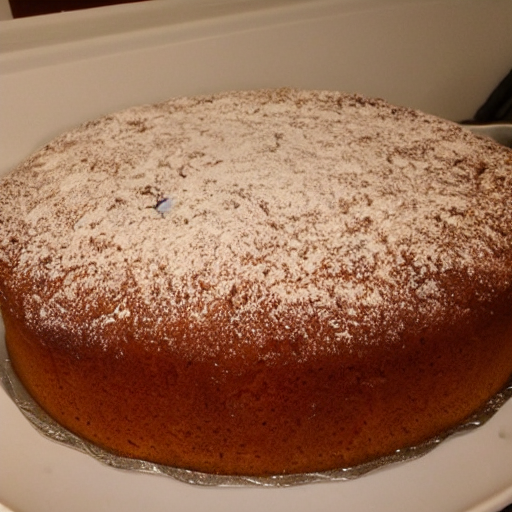

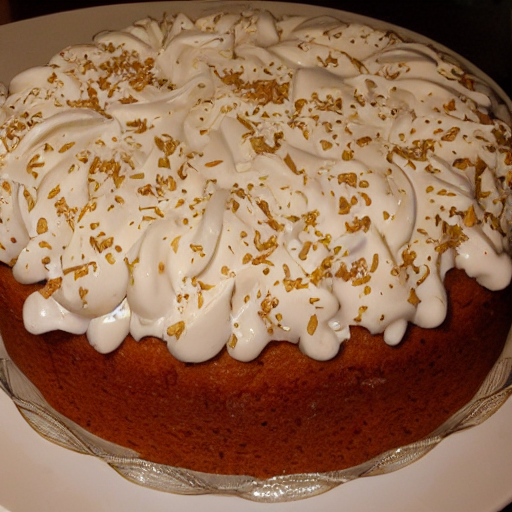

In [48]:
img1 = stablediffusion(prompt, seed=seed)
img2 = stablediffusion(prompt, prompt.replace('apple', 'birthday'), seed=seed)
display(*[img1, img2])

0: <|startoftext|>
1: a
2: photo
3: of
4: a
5: young
6: man
7: with
8: brown
9: hair
10: ,
11: a
12: closed
13: mouth
14: ,
15: pale
16: skin
17: and
18: open
19: eyes
20: <|endoftext|>


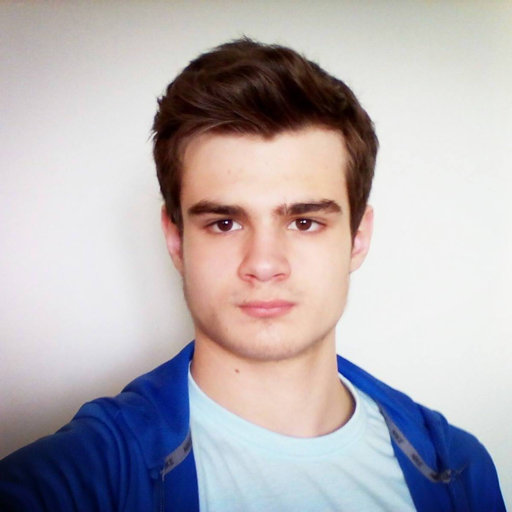

In [34]:
prompt = 'A photo of a young man with brown hair, a closed mouth, pale skin and open eyes'
img = Image.open('adam.jpg').resize((512, 512))
show_token_indices(prompt)
img

  0%|          | 0/32 [00:00<?, ?it/s]

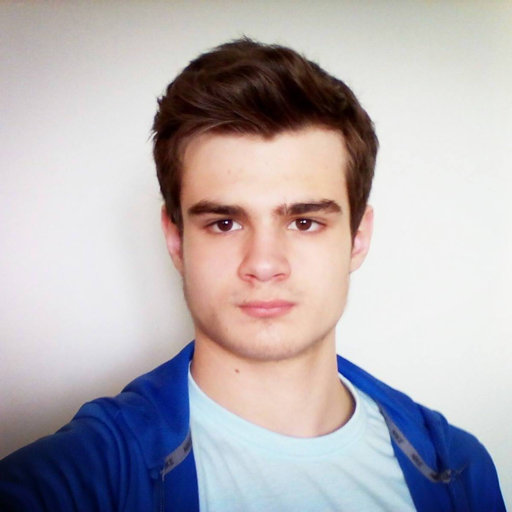

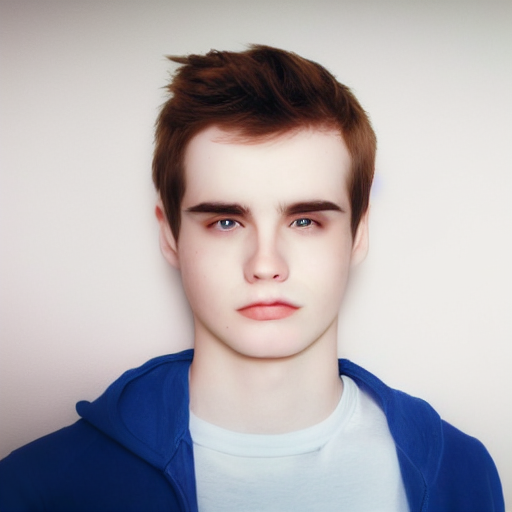

In [37]:
result = stablediffusion(prompt, prompt.replace('open', 'closed'), seed=seed, 
                         init_image=img, init_image_strength=0.65)
display(*[img, result])